In [1]:
# Set up AMD GPU (change if using Nvidia)
import plaidml.keras
plaidml.keras.install_backend()

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix

In [4]:
from keras import callbacks, models, layers

# Read data

In [ ]:
dataLoc = '../data/'

In [5]:
data = pd.read_csv(dataLoc+'fires_merged_weather.csv', index_col=0,
                  #dtype for smaller representation
                  dtype={'STAT_CAUSE_DESCR': 'category', 'STATE': 'category', 'DISCOVERY_MONTH': 'category',
                        'Fog': 'bool', 'FunnelCloud': 'bool', 'Hail': 'bool', 'Rain': 'bool',
                        'Snow': 'bool', 'Thunder': 'bool'}
                  )

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


# Drop unnecessary columns

In [6]:
data.drop(['Unnamed: 0.1', 'index_x', 'FOD_ID', 'FIRE_NAME', 'DISCOVERY_DOY_SCALED',
           'x_fire', 'y_fire', 'z_fire',
           'index_y', 'Begin', 'End', 'Country', 'Day', 'ICAO', 'Latitude', 'Longitude', 'Month', 'STATION NAME',
           'State', 'Station', 'USAF', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1', 
           'WBAN', 'Year', 'doy', 'x', 'y', 'z',
          ],
         axis='columns', inplace=True)

In [7]:
gc.collect()

2476

In [8]:
data.columns

Index(['STAT_CAUSE_DESCR', 'FIRE_YEAR', 'DISCOVERY_DOY', 'FIRE_SIZE',
       'LATITUDE', 'LONGITUDE', 'STATE', 'CONTAINED', 'DISCOVERY_MONTH',
       'DISTANCE_CITY_1000000', 'DISTANCE_CITY_100000', 'DISTANCE_CITY_10000',
       'DISTANCE_CITY_1000', 'APPROX_ELEVATION', 'DewPoint', 'Elevation',
       'Fog', 'FunnelCloud', 'Gust', 'Hail', 'MaxTemp', 'MaxWindspeed',
       'MinTemp', 'Precip', 'Rain', 'SeaLevelPressure', 'Snow', 'SnowDepth',
       'StationPressure', 'Temp', 'Thunder', 'Visibility', 'Windspeed'],
      dtype='object')

# Only use fires from 2015

In [9]:
data = data[data["FIRE_YEAR"] == 2015]

# Drop unknown fires

In [10]:
data = data[data['STAT_CAUSE_DESCR'] != 'Missing/Undefined']
data = data[data['STAT_CAUSE_DESCR'] != 'Miscellaneous']

In [11]:
gc.collect()

80

# Split into features/labels and one-hot code

Also convert missing values to `np.nan`.

In [12]:
data.drop('STAT_CAUSE_DESCR', axis='columns').columns

Index(['FIRE_YEAR', 'DISCOVERY_DOY', 'FIRE_SIZE', 'LATITUDE', 'LONGITUDE',
       'STATE', 'CONTAINED', 'DISCOVERY_MONTH', 'DISTANCE_CITY_1000000',
       'DISTANCE_CITY_100000', 'DISTANCE_CITY_10000', 'DISTANCE_CITY_1000',
       'APPROX_ELEVATION', 'DewPoint', 'Elevation', 'Fog', 'FunnelCloud',
       'Gust', 'Hail', 'MaxTemp', 'MaxWindspeed', 'MinTemp', 'Precip', 'Rain',
       'SeaLevelPressure', 'Snow', 'SnowDepth', 'StationPressure', 'Temp',
       'Thunder', 'Visibility', 'Windspeed'],
      dtype='object')

#### Zero-imputing for some features -- see EDA.ipynb

In [13]:
Y = pd.get_dummies(data['STAT_CAUSE_DESCR'].cat.remove_unused_categories())
X = pd.get_dummies(data.drop('STAT_CAUSE_DESCR', axis='columns'))

for na in [9999.9, 999.9, 99.99]:
    X[X == na] = np.nan

In [14]:
for zcol in ['Gust', 'MaxWindspeed', 'Precip', 'SnowDepth', 'Visibility', 'Windspeed']:
    X.loc[X[zcol].isna(), zcol] = 0

In [15]:
X.shape

(50096, 94)

# Train/test split

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.1, random_state=42)

# Impute missing features

#### Mean imputing for some features -- see EDA.ipynb

In [17]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')

In [18]:
imp.fit(X_train)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='mean', verbose=0)

In [19]:
X_train = imp.transform(X_train)
X_test = imp.transform(X_test)

# Scale the features

In [20]:
scale = MinMaxScaler()

In [21]:
scale.fit(X_train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [22]:
X_train = scale.transform(X_train)
X_test = scale.transform(X_test)

# Define the model

In [23]:
model = models.Sequential()

model.add(layers.Dense(64, input_shape=(X.shape[1],)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.Dense(64))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.Dense(64))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))


model.add(layers.Dense(Y.shape[1], activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

INFO:plaidml:Opening device "opencl_amd_tonga.0"


In [24]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                6080      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
_________________________________________________________________
activation_2 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
__________

# Fit model

In [25]:
history = model.fit(x = X_train, y = Y_train,
                    validation_data = (X_test, Y_test),
                    batch_size = 10000, epochs=1000,
                    callbacks = [callbacks.EarlyStopping(patience=50)])

Train on 45086 samples, validate on 5010 samples
Epoch 1/1000
45086/45086 [==============================] - 25s 553us/step - loss: 2.2574 - categorical_accuracy: 0.2480 - val_loss: 2.3191 - val_categorical_accuracy: 0.2924
Epoch 2/1000
45086/45086 [==============================] - 0s 7us/step - loss: 1.8221 - categorical_accuracy: 0.4365 - val_loss: 2.2815 - val_categorical_accuracy: 0.3261
Epoch 3/1000
45086/45086 [==============================] - 0s 7us/step - loss: 1.6596 - categorical_accuracy: 0.4997 - val_loss: 2.2540 - val_categorical_accuracy: 0.3860
Epoch 4/1000
45086/45086 [==============================] - 0s 7us/step - loss: 1.5658 - categorical_accuracy: 0.5214 - val_loss: 2.2233 - val_categorical_accuracy: 0.4313
Epoch 5/1000
45086/45086 [==============================] - 0s 7us/step - loss: 1.5041 - categorical_accuracy: 0.5326 - val_loss: 2.1932 - val_categorical_accuracy: 0.4663
Epoch 6/1000
45086/45086 [==============================] - 0s 7us/step - loss: 1.4598 -

Epoch 48/1000
45086/45086 [==============================] - 0s 7us/step - loss: 1.1938 - categorical_accuracy: 0.5959 - val_loss: 1.5637 - val_categorical_accuracy: 0.5004
Epoch 49/1000
45086/45086 [==============================] - 0s 7us/step - loss: 1.1918 - categorical_accuracy: 0.5954 - val_loss: 1.5502 - val_categorical_accuracy: 0.5042
Epoch 50/1000
45086/45086 [==============================] - 0s 7us/step - loss: 1.1899 - categorical_accuracy: 0.5964 - val_loss: 1.5518 - val_categorical_accuracy: 0.5034
Epoch 51/1000
45086/45086 [==============================] - 0s 6us/step - loss: 1.1875 - categorical_accuracy: 0.5982 - val_loss: 1.5237 - val_categorical_accuracy: 0.5130
Epoch 52/1000
45086/45086 [==============================] - 0s 7us/step - loss: 1.1854 - categorical_accuracy: 0.5988 - val_loss: 1.5224 - val_categorical_accuracy: 0.5130
Epoch 53/1000
45086/45086 [==============================] - 0s 6us/step - loss: 1.1849 - categorical_accuracy: 0.5984 - val_loss: 1.53

45086/45086 [==============================] - 0s 6us/step - loss: 1.1317 - categorical_accuracy: 0.6138 - val_loss: 1.3099 - val_categorical_accuracy: 0.5673
Epoch 96/1000
45086/45086 [==============================] - 0s 6us/step - loss: 1.1338 - categorical_accuracy: 0.6129 - val_loss: 1.3074 - val_categorical_accuracy: 0.5725
Epoch 97/1000
45086/45086 [==============================] - 0s 6us/step - loss: 1.1313 - categorical_accuracy: 0.6160 - val_loss: 1.3014 - val_categorical_accuracy: 0.5764
Epoch 98/1000
45086/45086 [==============================] - 0s 6us/step - loss: 1.1287 - categorical_accuracy: 0.6159 - val_loss: 1.3077 - val_categorical_accuracy: 0.5731
Epoch 99/1000
45086/45086 [==============================] - 0s 6us/step - loss: 1.1292 - categorical_accuracy: 0.6137 - val_loss: 1.3080 - val_categorical_accuracy: 0.5705
Epoch 100/1000
45086/45086 [==============================] - 0s 7us/step - loss: 1.1275 - categorical_accuracy: 0.6154 - val_loss: 1.2954 - val_cate

45086/45086 [==============================] - 0s 6us/step - loss: 1.0939 - categorical_accuracy: 0.6254 - val_loss: 1.3106 - val_categorical_accuracy: 0.5741
Epoch 143/1000
45086/45086 [==============================] - 0s 7us/step - loss: 1.0970 - categorical_accuracy: 0.6265 - val_loss: 1.2862 - val_categorical_accuracy: 0.5822
Epoch 144/1000
45086/45086 [==============================] - 0s 6us/step - loss: 1.0926 - categorical_accuracy: 0.6255 - val_loss: 1.2877 - val_categorical_accuracy: 0.5806
Epoch 145/1000
45086/45086 [==============================] - 0s 6us/step - loss: 1.0923 - categorical_accuracy: 0.6278 - val_loss: 1.2911 - val_categorical_accuracy: 0.5844
Epoch 146/1000
45086/45086 [==============================] - 0s 6us/step - loss: 1.0932 - categorical_accuracy: 0.6270 - val_loss: 1.3045 - val_categorical_accuracy: 0.5709
Epoch 147/1000
45086/45086 [==============================] - 0s 6us/step - loss: 1.0915 - categorical_accuracy: 0.6267 - val_loss: 1.2897 - val_

45086/45086 [==============================] - 0s 7us/step - loss: 1.0673 - categorical_accuracy: 0.6322 - val_loss: 1.2993 - val_categorical_accuracy: 0.5788
Epoch 190/1000
45086/45086 [==============================] - 0s 6us/step - loss: 1.0674 - categorical_accuracy: 0.6343 - val_loss: 1.2913 - val_categorical_accuracy: 0.5872
Epoch 191/1000
45086/45086 [==============================] - 0s 6us/step - loss: 1.0653 - categorical_accuracy: 0.6340 - val_loss: 1.2973 - val_categorical_accuracy: 0.5830
Epoch 192/1000
45086/45086 [==============================] - 0s 6us/step - loss: 1.0671 - categorical_accuracy: 0.6332 - val_loss: 1.2932 - val_categorical_accuracy: 0.5812
Epoch 193/1000
45086/45086 [==============================] - 0s 6us/step - loss: 1.0671 - categorical_accuracy: 0.6345 - val_loss: 1.2953 - val_categorical_accuracy: 0.5844
Epoch 194/1000
45086/45086 [==============================] - 0s 6us/step - loss: 1.0638 - categorical_accuracy: 0.6337 - val_loss: 1.2946 - val_

In [26]:
data['STAT_CAUSE_DESCR'].groupby(data['STAT_CAUSE_DESCR']).count() / data.shape[0]

STAT_CAUSE_DESCR
Arson                0.132266
Campfire             0.074477
Children             0.026948
Debris Burning       0.366077
Equipment Use        0.109470
Fireworks            0.011678
Lightning            0.195864
Miscellaneous        0.000000
Missing/Undefined    0.000000
Powerline            0.031539
Railroad             0.007386
Smoking              0.037608
Structure            0.006687
Name: STAT_CAUSE_DESCR, dtype: float64

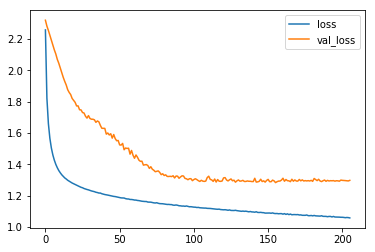

In [30]:
fig, ax = plt.subplots()
ax.plot(history.history['loss'], label='loss')
ax.plot(history.history['val_loss'], label='val_loss')
ax.legend()
plt.show()

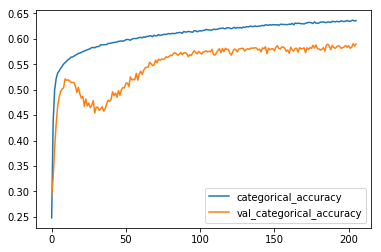

In [31]:
fig, ax = plt.subplots()
ax.plot(history.history['categorical_accuracy'], label='categorical_accuracy')
ax.plot(history.history['val_categorical_accuracy'], label='val_categorical_accuracy')
ax.legend()
plt.show()

In [27]:
Y_pred = model.predict(X_test)

In [28]:
C = confusion_matrix(np.argmax(Y_test.values, axis=-1), np.argmax(Y_pred, axis=-1))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


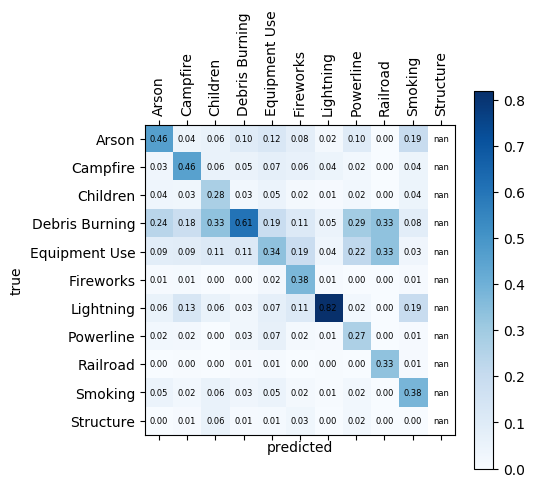

In [29]:
fig, ax = plt.subplots(figsize=(5,5), dpi=100)

Cnorm = C / C.sum(axis=0)

m = ax.matshow(Cnorm, cmap='Blues')
for i in range(11):
    for j in range(11):
        ax.text(j, i, '{:0.2f}'.format(Cnorm[i,j]), ha='center', va='center', fontsize=6)
        
fig.colorbar(m)

ax.set_ylabel("true")
plt.yticks(ticks=np.arange(11), labels=Y.columns)
plt.xticks(ticks=np.arange(11), labels=Y.columns, rotation=90)
ax.set_xlabel('predicted')
plt.show()